## SpeakFeel AI Exercise

Objectives:

Using Tensorflow and Python, build a LSTM model that will predict the temperature for the next day at the Capital Center, using the historical precipitation and temperature data in the supplied data set (attached CSV file). 

Along with the python file(s) please provide a brief description to explain your process, thinking, methodology and any key points for your solution.

Notes:
- Temperatures in the supplied CSV file are in fahrenheit.
- Precipitation is in inches

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\LLC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Outline
1. Data preparation
2. Modeling

3. Conclusion

-------------

### 1.1 Read table

In [2]:
raw = pd.read_csv('./data.csv', index_col='id')
raw.head()

,date,venue,temperature,precipitation
id,,,,
21700001,2017-10-17,Quicken Loans Arena,53.51,0.0000
21700002,2017-10-17,Oracle Arena,81.79,0.0000
21700003,2017-10-18,Little Caesars Arena,67.30,0.0000
21700004,2017-10-18,Bankers Life Fieldhouse,65.36,0.0000
21700005,2017-10-18,Amway Center,75.14,0.0005


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2132 entries, 21700001 to 1621800006
Data columns (total 4 columns):
date             2132 non-null object
venue            2132 non-null object
temperature      2132 non-null float64
precipitation    2106 non-null float64
dtypes: float64(2), object(2)
memory usage: 83.3+ KB


In [4]:
raw.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,2132.0,56.077603,19.693321,-6.73,41.5725,56.12,70.4,112.940
precipitation,2106.0,0.002723,0.014793,0.00,0.0000,0.00,0.0,0.257


### 1.2 Foundings

- Goal: To predict temperature of Capital Center on the next day(2019-01-24), since the last date appears in data is 2019-01-23.

As there is a certain physical distance between other 27 arenas and Capital Center(I could be wrong), I assumed the weather of the other 27 arenas barely affect the temperature at 'Capital Center'. Thus, I first filered out data where venue is 'Capital Center'.

In [5]:
cc = raw[raw.venue == 'Capital Center'].sort_values('date')
cc.head()

,date,venue,temperature,precipitation
id,,,,
1521700024,2017-07-10,Capital Center,83.32,0.0
1521700033,2017-07-11,Capital Center,88.11,0.0
21700006,2017-10-18,Capital Center,58.99,0.0
21700020,2017-10-20,Capital Center,68.67,0.0
21700108,2017-11-01,Capital Center,50.96,0.0


Great, no missing value.

In [6]:
cc.isnull().sum()

date             0
venue            0
temperature      0
precipitation    0
dtype: int64

In [7]:
tmp = cc.copy()
tmp['date'] = pd.to_datetime(tmp['date'])
tmp['date_after'] = pd.to_datetime(cc.date.shift(periods=-1, fill_value=cc.date.iloc[-1]))
tmp['days_after'] = tmp['date_after'] - tmp['date']
tmp.head()

,date,venue,temperature,precipitation,date_after,days_after
id,,,,,,
1521700024,2017-07-10,Capital Center,83.32,0.0,2017-07-11,1 days
1521700033,2017-07-11,Capital Center,88.11,0.0,2017-10-18,99 days
21700006,2017-10-18,Capital Center,58.99,0.0,2017-10-20,2 days
21700020,2017-10-20,Capital Center,68.67,0.0,2017-11-01,12 days
21700108,2017-11-01,Capital Center,50.96,0.0,2017-11-03,2 days


#### This filtered data has unevenly-spaced time interval. Looks like it does not record during offseason, and only record on game day I guess?

In [8]:
tmp.days_after.value_counts().sort_index()

0 days      1
1 days      3
2 days     27
3 days      3
4 days     12
5 days      2
6 days      6
7 days      3
8 days      2
11 days     1
12 days     2
13 days     1
15 days     2
87 days     1
99 days     2
Name: days_after, dtype: int64

#### Want to predict temperature of the next day, which is '2019-01-24'.

In [9]:
tmp.tail()

,date,venue,temperature,precipitation,date_after,days_after
id,,,,,,
21800608,2019-01-09,Capital Center,53.26,0.0000,2019-01-11,2 days
21800622,2019-01-11,Capital Center,32.03,0.0000,2019-01-13,2 days
21800639,2019-01-13,Capital Center,30.62,0.0012,2019-01-17,4 days
21800665,2019-01-17,Capital Center,39.73,0.0000,2019-01-21,4 days
21800693,2019-01-21,Capital Center,27.80,0.0000,2019-01-21,0 days


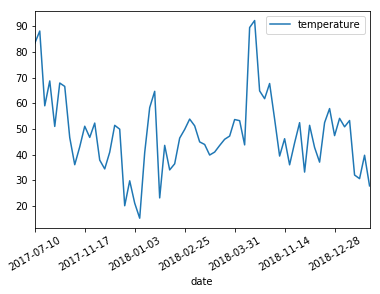

In [10]:
cc.plot('date', 'temperature', rot=30)

### 1.3 Preprocessing

In [11]:
def df_to_supervised(df, max_days_after=10):
    """
    transform the original time series to a supervised learning dataset.
        df: pd.DataFrame, a multivariate time series
        max_days_after: int, prevent a prediction on a long time after.
        
    returns: df_, a pd.DataFrame prepared for supervised learning.
    """
    df_ = df.sort_values('date').copy()
    
    df_['date'] = pd.to_datetime(df_['date'])
    df_['date_after'] = pd.to_datetime(df_['date'].shift(periods=-1, fill_value=df_['date'].iloc[-1]))
    df_['days_after'] = (df_['date_after'] - df_['date']).dt.days
    df_['month'] = df_['date_after'].dt.month
    df_['y'] = df_['temperature'].shift(periods=-1, fill_value=df_['temperature'].iloc[-1])
    
    df_ = df_[['month', 'temperature', 'precipitation', 'days_after', 'y']]
    df_ = df_[df_['days_after'] <= max_days_after]
    
    # Last record does not have label(future temperature), so it is removed
    df_ = df_.iloc[:-1]
    
    return df_

In [12]:
cc_ready = df_to_supervised(cc)
cc_ready.tail()

,month,temperature,precipitation,days_after,y
id,,,,,
21800556,1,50.81,0.0000,7,53.26
21800608,1,53.26,0.0000,2,32.03
21800622,1,32.03,0.0000,2,30.62
21800639,1,30.62,0.0012,4,39.73
21800665,1,39.73,0.0000,4,27.80


### 2. Modeling

#### 2.1 train test split

It is a small dataset with less than 68 observations, so I only split it into train/dev(no test set).

In [13]:
def scale_split(df, train_ratio=0.65):
    n_train = int(df.values.shape[0]*0.65)
    X = df.drop('y', axis=1).values
    y = df['y'].values.reshape(df.shape[0], 1)
    
    X_scaler = StandardScaler()
    X = X_scaler.fit_transform(X)
    
    y_scaler = StandardScaler()
    y = y_scaler.fit_transform(y)
    
    X_train, y_train = X[:n_train, :], y[:n_train]
    X_test, y_test = X[n_train:, :], y[n_train:]
    
    return X_train, y_train, X_test, y_test, X_scaler, y_scaler

X_train, y_train, X_test, y_test, X_scaler, y_scaler = scale_split(cc_ready)
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [14]:
n_train = y_train.shape[0]
n_test = y_test.shape[0]
print(n_train, X_train.shape, y_train.shape)
print(n_test, X_test.shape, y_test.shape)

37 (37, 1, 4) (37, 1)
21 (21, 1, 4) (21, 1)


After trying different combination of hyper-parameters, this is the best combo so far.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


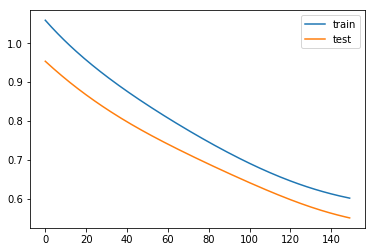

Test RMSE: 10.499


In [15]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
reg = model.fit(X_train, 
                y_train, 
                epochs=150, 
                batch_size=X_train.shape[0], 
                validation_data=(X_test, y_test), 
                verbose=0, 
                shuffle=False)

# plot history
plt.plot(reg.history['loss'], label='train')
plt.plot(reg.history['val_loss'], label='test')
plt.legend()
plt.show()

y_pred = model.predict(X_test)

# calculate RMSE
rmse = mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(y_pred)) ** 0.5
print('Test RMSE: %.3f' % rmse)

It is weird that loss on test set is lower then on train set.

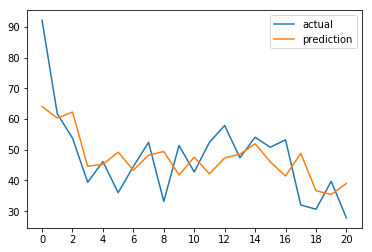

In [16]:
plt.locator_params(axis='x', nbins=15)
plt.plot(range(n_test), y_scaler.inverse_transform(y_test), label='actual')
plt.plot(range(n_test), y_scaler.inverse_transform(y_pred), label='prediction')
# plt.xticks(rotation=30)
plt.legend()

In [17]:
cc.iloc[-1]

date                 2019-01-21
venue            Capital Center
temperature                27.8
precipitation                 0
Name: 21800693, dtype: object

In [18]:
X_190124 = X_scaler.fit_transform(np.array([1, 27.8, 0, 3]).reshape(4,1)).reshape(1,1,4)

y_190124 = round(float(y_scaler.inverse_transform(model.predict(X_190124))), 2)
print(f'Model tells us the temperature of Capital Center on 2019-01-24 would be {y_190124}°F')

Model tells us the temperature of Capital Center on 2019-01-24 would be 60.98°F


In [19]:
model.save('./model0.hdf5')

### Conclusion

First I was disappointed at my model since 4 days ago it was only 27.8°F. Then I checked the actual temperature. But it surprised me that the tempurature did go up to around 57°F before 12pm! Although it did cool down later because of a sudden heavy rain.


<img src="https://user-images.githubusercontent.com/43755001/54408661-09dec800-46b9-11e9-8658-7f168d262f2c.png" style="width:400;height:200px;">

screenshot from: [source](https://www.wunderground.com/personal-weather-station/dashboard?ID=KMDHYATT11&scrollTo=historyTable#history/s20190124/e20190124/mdaily)


Afterall, it could definitely be improved with more time. Reforming the dataframe to include more than just one past record for each observation and/or also training model on other 27 venues might help.

Any advice would be appreciated and thanks for reading my work.

-------

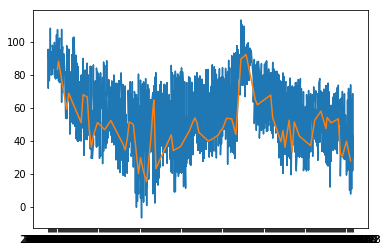

In [20]:
# Comparation between temperature at Capital Center and other 27 venues.
plt.plot(raw[raw.venue != 'Capital Center'].sort_values('date').date, raw[raw.venue != 'Capital Center'].sort_values('date').temperature)
plt.plot(raw[raw.venue == 'Capital Center'].sort_values('date').date, raw[raw.venue == 'Capital Center'].sort_values('date').temperature)
# plt.plot(df[df.isnull().any(axis=1)].sort_values('date').date, df[df.isnull().any(axis=1)].sort_values('date').temperature)